#               Epilepsy Detection using EEG Brain Signals

This code is related to the following section of [the paper](https://arxiv.org/abs/2403.17181):

## Section VII: Applications
### B. Epilepsy Detection using EEG Brain Signals

The section facilitates epilepsy detection using EEG brain signals, where where wavelet packet transform (WPT) is used to decompose the signals into their elementary modes. Accordingly, the energy of each mode is calculated, facilitating efficient EEG energy-based epilepsy detection.
For more details please refer to [the paper](https://arxiv.org/abs/2403.17181).

In [1]:
from scipy.io import loadmat
from numpy import asarray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.matlib
from scipy import signal
from scipy.signal import welch
from scipy.stats import entropy
from scipy.fft import fft, fftfreq
import pywt
import os
import glob
from warnings import warn
from sklearn import metrics
plt.rc('font',family='Times New Roman')
import warnings 
warnings.filterwarnings('ignore')

In [2]:
def signal_energy(signal):
    # Calculate the energy by summing the squares of the amplitude values
    energy = sum(value**2 for value in signal)
    return energy

In [3]:
def make_dataset(data_src):
    files = glob.glob(data_src)
    dataset_df = []
    for file in files:
        dataset_df.append(pd.read_csv(file, header = None))
    dataset = pd.concat(dataset_df, ignore_index=True, axis= 1)
    return dataset.T

==========================================================================================================================
# Dataset Creatioin:
=========================================================================================================================== 

## Grouping vibration signals in required folders to  generate the dataset
 
Link to download the University of Bonn (UoB) EEG dataset dataset: https://www.ukbonn.de/epileptologie/arbeitsgruppen/ag-lehnertz-neurophysik/downloads/ <br>
The EEG signals are grouped according to their operational conditions in 5 folders (A-E): 

A ===>	Z.zip 	
B ===> 	O.zip	
C ===>	N.zip 	
D ===>	F.zip  	
E ===>	S.zip 	

In [4]:
data_path = (r"D:\bonn_uni_datasets") # path to the 4 folders.
A  = make_dataset(os.path.join(data_path,  'A/*'))
B  = make_dataset(os.path.join(data_path,  'B/*'))
C  = make_dataset(os.path.join(data_path,  'C/*'))
D  = make_dataset(os.path.join(data_path,  'D/*'))
E  = make_dataset(os.path.join(data_path,  'E/*'))

In [5]:
normal = A.append(B).reset_index(drop = True).to_numpy()
interictal = C.append(D).reset_index(drop = True).to_numpy()
ictal = E.to_numpy()

In [6]:
num_samples =500 # Length of input segment
###########################################
fs =  173.61; # Sampling freq.

In [7]:
# Segmenting EEG signals:

data = normal.reshape(-1)
num_segments = np.floor(len(data)/num_samples)
slices = np.split(data[0:int(num_segments*num_samples)], num_samples)
normal = np.array(slices).reshape(int(num_segments), num_samples)
data = interictal.reshape(-1)
num_segments = np.floor(len(data)/num_samples)
slices = np.split(data[0:int(num_segments*num_samples)], num_samples)
interictal = np.array(slices).reshape(int(num_segments), num_samples)
data = ictal.reshape(-1)
num_segments = np.floor(len(data)/num_samples)
slices = np.split(data[0:int(num_segments*num_samples)], num_samples)
ictal = np.array(slices).reshape(int(num_segments), num_samples)

In [8]:
normal_labels = np.zeros(len(normal))
interictal_labels = np.ones(len(interictal))
ictal_labels = np.ones(len(ictal))*2
X = np.concatenate( (normal, interictal, ictal) , axis=0, out=None)
Y = np.concatenate( (normal_labels, interictal_labels, ictal_labels ) , axis=0, out=None)
print("data set features size:", X.shape)
print("data set labels size:", Y.shape)
print(X.shape)

data set features size: (4095, 500)
data set labels size: (4095,)
(4095, 500)


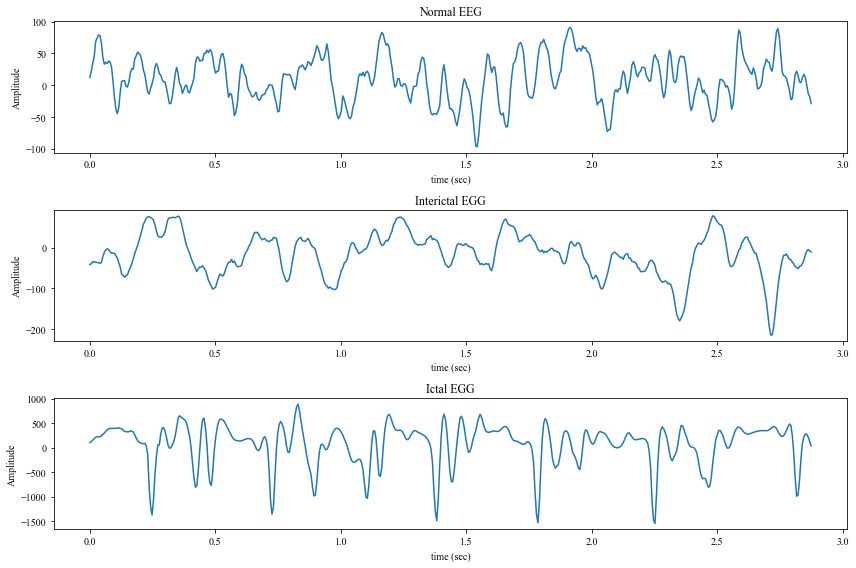

In [9]:
# Sample EEG signals representing the three classes of the UoB dataset.

index = 0

normal_EEG = normal[0]
interictal_EGG = interictal[0]
ictal_EGG = ictal[0]
time = np.arange(0.0, len(normal_EEG), 1.0)/fs
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(time, normal_EEG)
plt.xlabel('time (sec)')
plt.ylabel('Amplitude')
plt.title("Normal EEG")
plt.subplot(3, 1, 2)
plt.plot(time, interictal_EGG)
plt.xlabel('time (sec)')
plt.ylabel('Amplitude')
plt.title("Interictal EGG")
plt.subplot(3, 1, 3)
plt.plot(time, ictal_EGG)
plt.xlabel('time (sec)')
plt.ylabel('Amplitude')
plt.title("Ictal EGG")
plt.tight_layout()
plt.show()

In [10]:
# Available wavelet functions:
for family in pywt.families():
    print("%s family: " % family + ', '.join(pywt.wavelist(family)))

haar family: haar
db family: db1, db2, db3, db4, db5, db6, db7, db8, db9, db10, db11, db12, db13, db14, db15, db16, db17, db18, db19, db20, db21, db22, db23, db24, db25, db26, db27, db28, db29, db30, db31, db32, db33, db34, db35, db36, db37, db38
sym family: sym2, sym3, sym4, sym5, sym6, sym7, sym8, sym9, sym10, sym11, sym12, sym13, sym14, sym15, sym16, sym17, sym18, sym19, sym20
coif family: coif1, coif2, coif3, coif4, coif5, coif6, coif7, coif8, coif9, coif10, coif11, coif12, coif13, coif14, coif15, coif16, coif17
bior family: bior1.1, bior1.3, bior1.5, bior2.2, bior2.4, bior2.6, bior2.8, bior3.1, bior3.3, bior3.5, bior3.7, bior3.9, bior4.4, bior5.5, bior6.8
rbio family: rbio1.1, rbio1.3, rbio1.5, rbio2.2, rbio2.4, rbio2.6, rbio2.8, rbio3.1, rbio3.3, rbio3.5, rbio3.7, rbio3.9, rbio4.4, rbio5.5, rbio6.8
dmey family: dmey
gaus family: gaus1, gaus2, gaus3, gaus4, gaus5, gaus6, gaus7, gaus8
mexh family: mexh
morl family: morl
cgau family: cgau1, cgau2, cgau3, cgau4, cgau5, cgau6, cgau7, 

In [11]:
# Selected wavelt function: 
wavelet_function = 'db6'

In [12]:
num_levels = pywt.dwt_max_level(len(X[0]), pywt.Wavelet(wavelet_function).dec_len)

print("Maximum level of decomposition:", num_levels)

Maximum level of decomposition: 5


In [13]:
num_features = 2**num_levels
print("Number of features:", num_features)

Number of features: 32


In [14]:
# Features calculation:
 
wavelet_energy_features = np.repeat(np.nan, len(X)*num_features).reshape(len(X),num_features)

for i in range(len(X)):
    #sig_in = filtfilt(b, a, X[i])
    sig_in = X[i]
    # wavelet packet transform (WPT)
    wp = pywt.WaveletPacket(sig_in, wavelet = wavelet_function , mode='symmetric',  maxlevel = num_levels) # Wavelet packet transformation
    packet_names = [node.path for node in wp.get_level(num_levels, "natural")]
    for j in range(num_features):
        new_wp = pywt.WaveletPacket(data = None, wavelet = wavelet_function,  mode='symmetric', maxlevel = num_levels)
        new_wp[packet_names[j]] = wp[packet_names[j]].data
        reconstructed_signal = new_wp.reconstruct(update = False) # Signal reconstruction from wavelet packet coefficients
        
        # Compute energy of reconstructed signal for every node (elementary mode)
        wavelet_energy_features[i,j] = signal_energy(reconstructed_signal)     

Maximum level of decomposition: 5


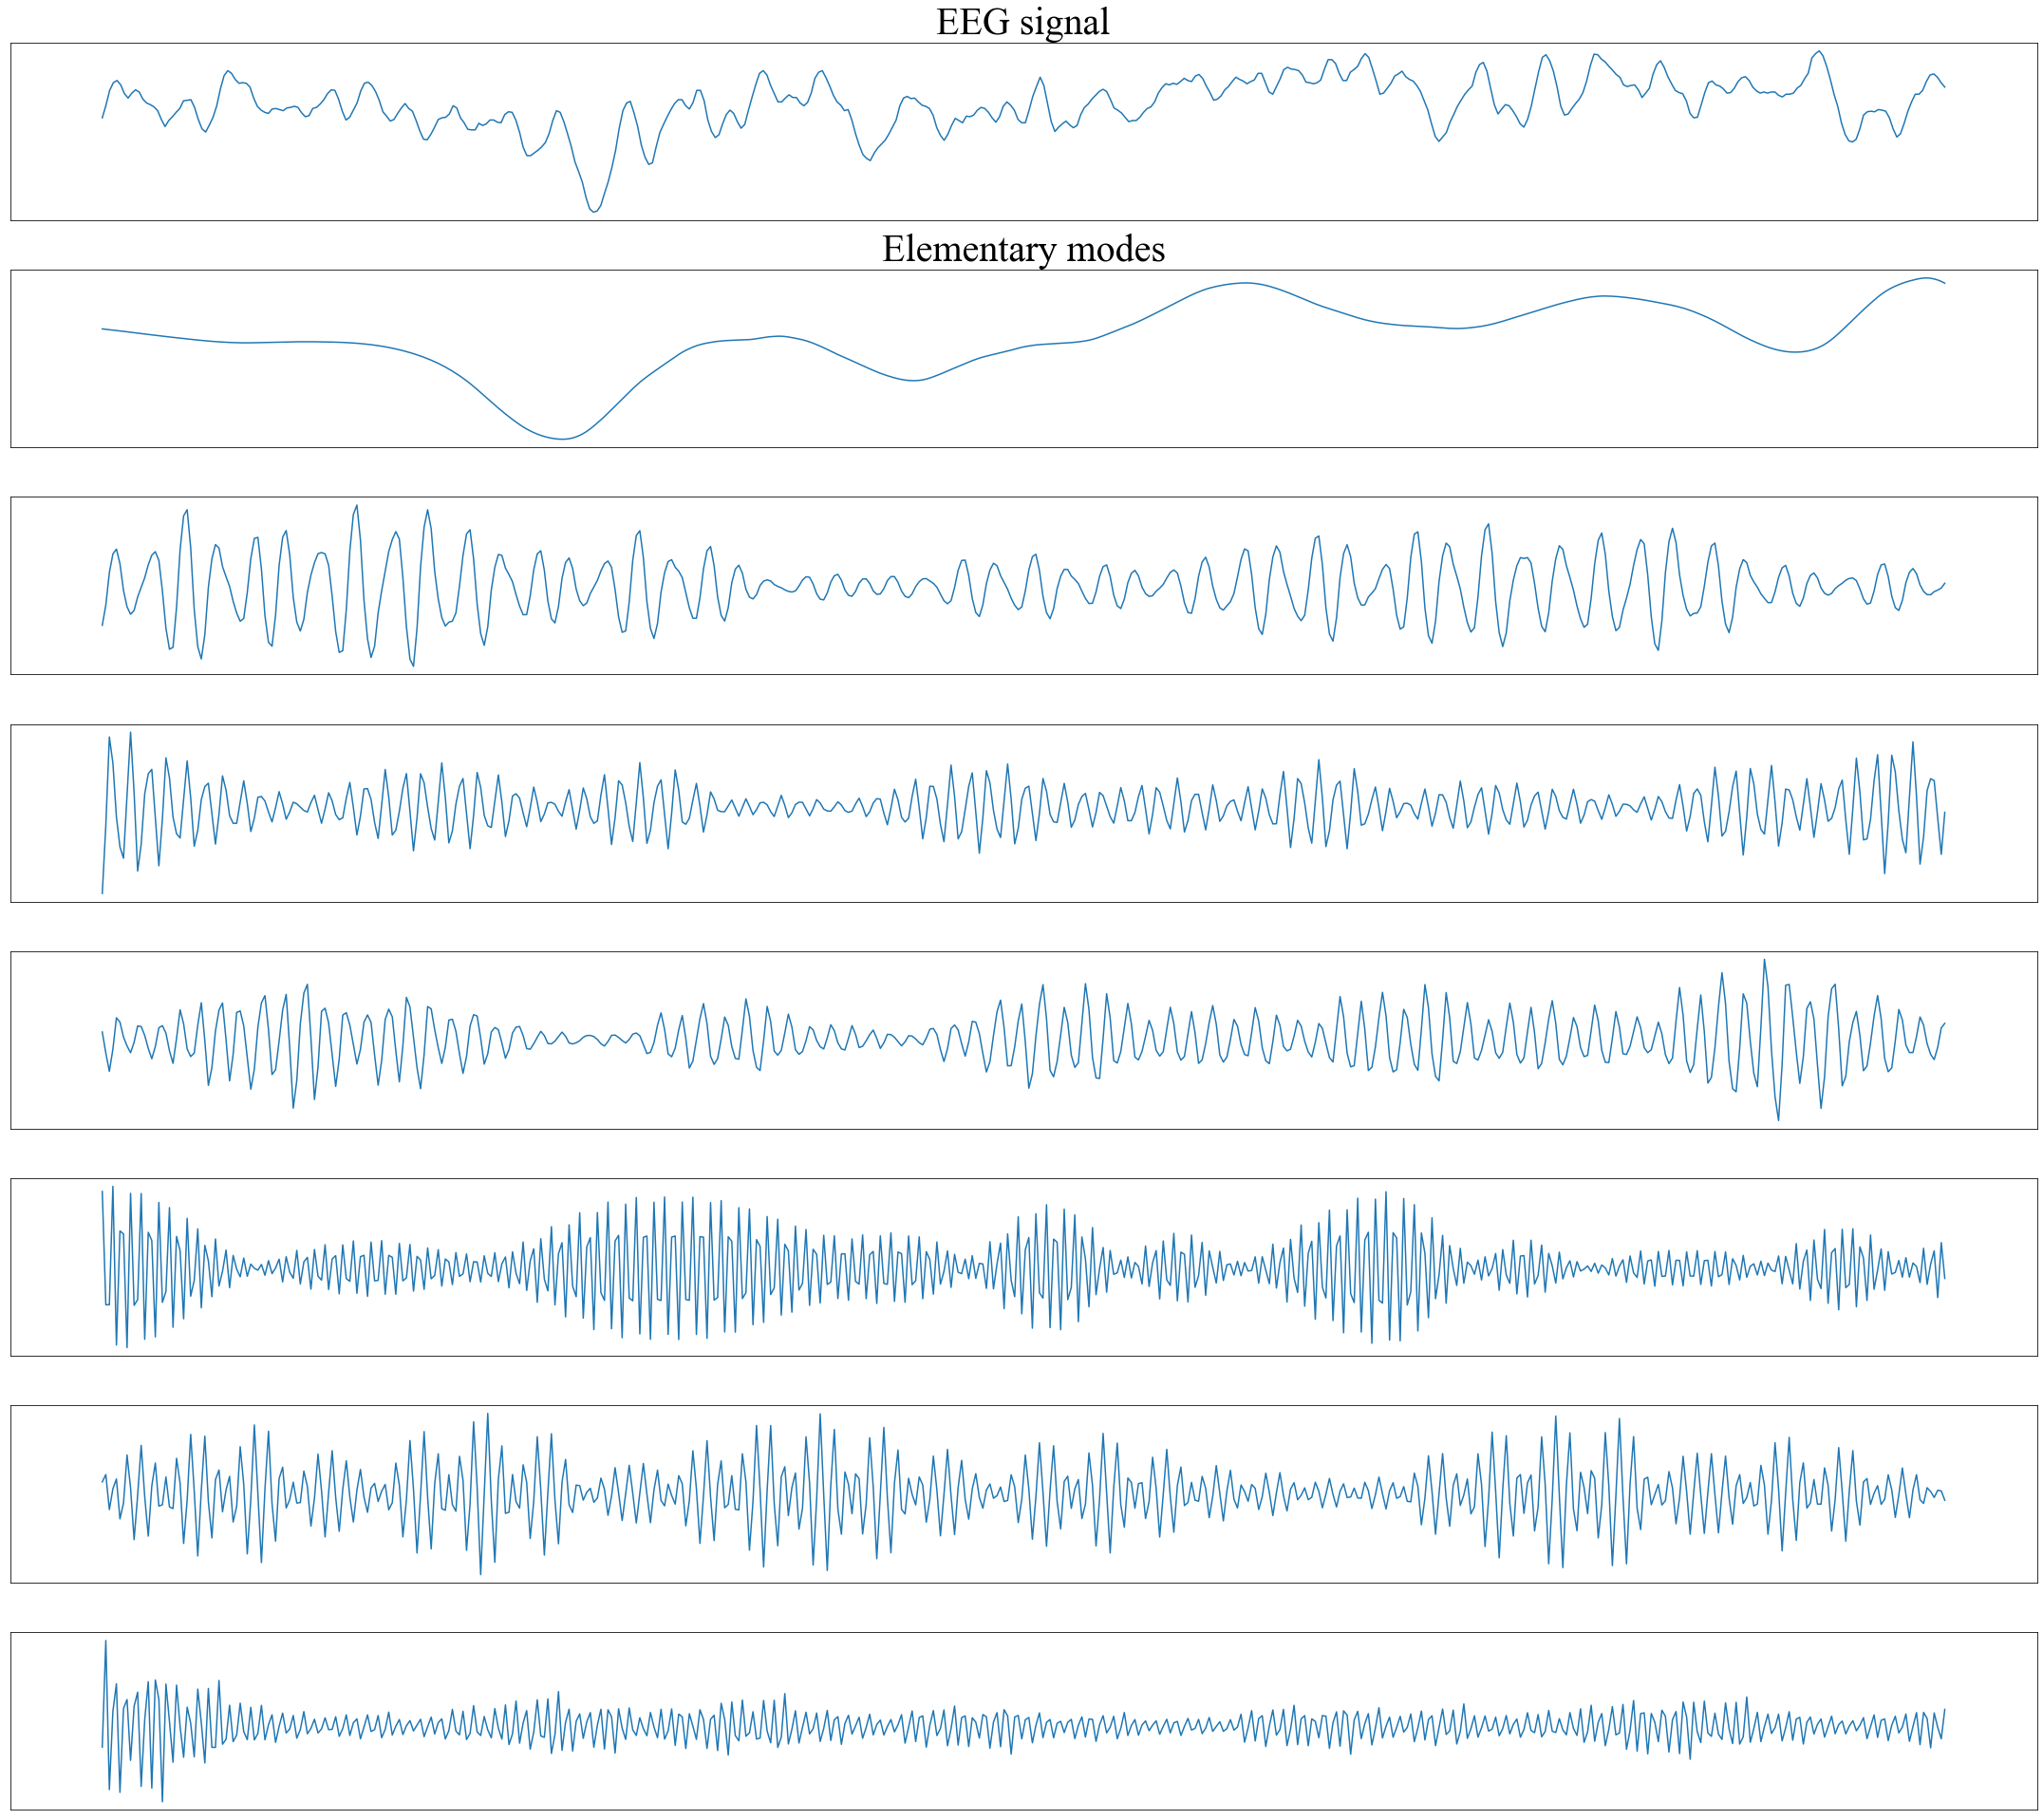

In [15]:
# EEG signal along with some of its constructed elementary modes.

x = X[1]
wp0 = pywt.WaveletPacket(x, wavelet = wavelet_function , mode='symmetric',  maxlevel = num_levels)
packet_names = [node.path for node in wp0.get_level(num_levels, "natural")]
print("Maximum level of decomposition:", num_levels)

plt.figure(figsize=(30, 30))

plt.subplot(9, 1, 1)
plt.plot(x)
plt.title("EEG signal", fontsize = 40)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.subplot(9, 1, 2)
new_wp0 = pywt.WaveletPacket(data = None, wavelet = wavelet_function,  mode='symmetric', maxlevel = num_levels)
new_wp0[packet_names[0]] = wp0[packet_names[0]].data
reconstructed_signal0 = new_wp0.reconstruct(update = False)
plt.plot(reconstructed_signal0)
plt.title("Elementary modes", fontsize = 40)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.subplot(9, 1, 3)
new_wp0 = pywt.WaveletPacket(data = None, wavelet = wavelet_function, maxlevel = num_levels)
new_wp0[packet_names[5]] = wp0[packet_names[5]].data
reconstructed_signal1 = new_wp0.reconstruct(update = False)
plt.plot(reconstructed_signal1)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.subplot(9, 1, 4)
new_wp0 = pywt.WaveletPacket(data = None, wavelet = wavelet_function, maxlevel = num_levels)
new_wp0[packet_names[10]] = wp0[packet_names[10]].data
reconstructed_signal2 = new_wp0.reconstruct(update = False)
plt.plot(reconstructed_signal2)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.subplot(9, 1, 5)
new_wp0 = pywt.WaveletPacket(data = None, wavelet = wavelet_function, maxlevel = num_levels)
new_wp0[packet_names[15]] = wp0[packet_names[15]].data
reconstructed_signal3 = new_wp0.reconstruct(update = False)
plt.plot(reconstructed_signal3)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.subplot(9, 1, 6)
new_wp0 = pywt.WaveletPacket(data = None, wavelet = wavelet_function, maxlevel = num_levels)
new_wp0[packet_names[20]] = wp0[packet_names[20]].data
reconstructed_signal4 = new_wp0.reconstruct(update = False)
plt.plot(reconstructed_signal4)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.subplot(9, 1, 7)
new_wp0 = pywt.WaveletPacket(data = None, wavelet = wavelet_function, maxlevel = num_levels)
new_wp0[packet_names[25]] = wp0[packet_names[25]].data
reconstructed_signal5 = new_wp0.reconstruct(update = False)
plt.plot(reconstructed_signal5)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.subplot(9, 1, 8)
new_wp0 = pywt.WaveletPacket(data = None, wavelet = wavelet_function, maxlevel = num_levels)
new_wp0[packet_names[31]] = wp0[packet_names[31]].data
reconstructed_signal6 = new_wp0.reconstruct(update = False)
plt.plot(reconstructed_signal6)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.tight_layout()

plt.show()

In [16]:
from skopt import Optimizer
from skopt import BayesSearchCV 
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix

In [17]:
labels = Y

In [18]:
X_train, X_test, y_train, y_test = train_test_split(wavelet_energy_features, labels, 
                                                    test_size = 0.2, stratify = labels, random_state = 123)

In [19]:
X_train.shape

(3276, 32)

In [20]:
X_test.shape

(819, 32)

In [21]:
scaler = StandardScaler() 
train_data_scaled = scaler.fit_transform(X_train)
test_data_scaled = scaler.transform(X_test)

In [22]:
clf_RF = RandomForestClassifier(criterion='gini', max_features =8, min_samples_leaf=1, min_samples_split=2, 
                                max_depth=200, n_estimators=1000, random_state= 42)
best_clf = clf_RF.fit(train_data_scaled, y_train) # max_features =8

In [23]:
train_predictions = best_clf.predict(train_data_scaled)
test_predictions = best_clf.predict(test_data_scaled)

In [24]:
train_confu_matrix = confusion_matrix(y_train, train_predictions)
test_confu_matrix = confusion_matrix(y_test, test_predictions)

ROC AUC = 0.999
F1 Score = 0.9865689865689866
Accuracy = 98.657 %
Wavelt function: db6


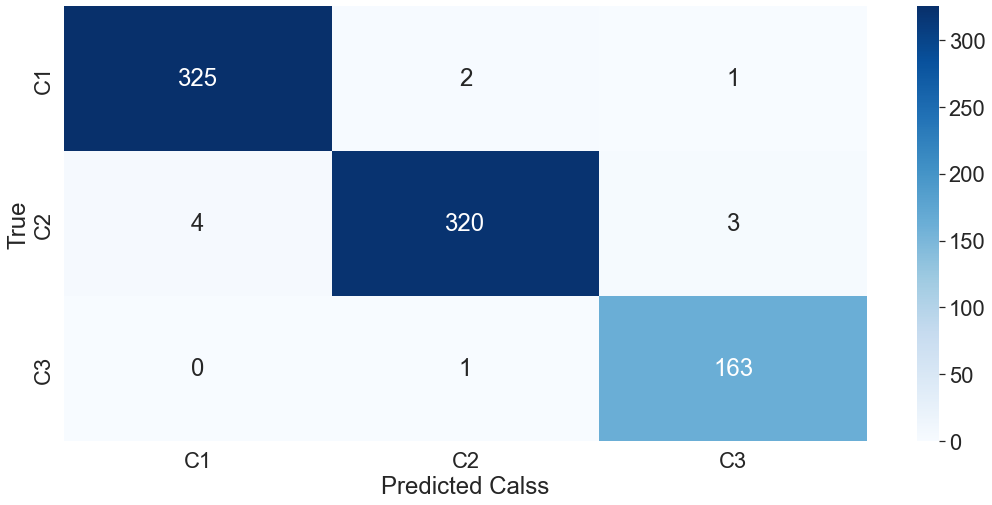

In [25]:
test_predictions = best_clf.predict(test_data_scaled)
test_confu_matrix = confusion_matrix(y_test, test_predictions)
fault_type = ['C1','C2','C3']
plt.figure(1,figsize=(18,8))
sns.set(font_scale=2)
sns.heatmap(test_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues")
plt.xlabel('Predicted Calss')
plt.ylabel('True Class')
plt.ylabel('True')
Accuracy = metrics.accuracy_score(y_test, test_predictions)
F1_score = metrics.f1_score(y_test, test_predictions, average='micro')
probs = best_clf.predict_proba(test_data_scaled)
lr_auc = roc_auc_score(y_test, probs, multi_class='ovr')
print('ROC AUC = %.3f' % (lr_auc))
print("F1 Score =", F1_score)
print("Accuracy = %.3f" % (Accuracy*100), "%")
print("Wavelt function:", wavelet_function)